## Семинар 8: Линейные модели

In [33]:
from scipy.io import loadmat
from io import BytesIO
import requests

from sklearn.metrics import mean_squared_error
from sklearn         import linear_model

import matplotlib.ticker as ticker
import matplotlib.pyplot as plt
import seaborn as sns
import pandas  as pd
import numpy   as np
import scipy   as sp

In [8]:
def get_features_and_label(dataset, is_training):
    """
    Gets matrices representing features and target from the original data set
    Parameters
    ----------
    dataset: DataFrame
      Original dataset
    is_training : str
      Label to show whether a data point is in training data or not.
        * "T" -> Training data
        * "F" -> Test data
    Return
    ------
      X : ndarray
        Feature matrix
      y : ndarray
        Lpsa values of each data point.
    """
    X = dataset.loc[dataset.train == is_training].drop("train", axis=1)
    y = X.pop("lpsa")
    return X, y


### Набор данных

Prostate Cancer Dataset (Набор данных рака предстательной железы)

Набор данных состоит из 97 наблюдений и 10 переменных (из которых 8 числовых переменных и одна категориальная переменная и является ID), которые выглядят следующим образом:

| Признак | Описание                           |
|---------|------------------------------------|
| lcavol  | (log) Cancer Volume                |
| lweight | (log) Weight                       |
| age     | Patient age                        |
| lbph    | (log) Vening Prostatic Hyperplasia |
| svi     | Seminal Vesicle Invasion           |
| lcp     | (log) Capsular Penetration         |
| gleason | Gleason score                      |
| pgg45   | Percent of Gleason score 4 or 5    |
| lpsa    | (log) Prostate Specific Antigen    |



In [9]:
path = "data/prostate.csv"
X = pd.read_csv(path, sep="\t").iloc[:, 1:]
X_train, y_train = get_features_and_label(X, "T")
X_test , y_test  = get_features_and_label(X, "F")

print(type(X_train))

<class 'pandas.core.frame.DataFrame'>


In [10]:
from sklearn.preprocessing import StandardScaler

scaler   = StandardScaler().fit(X.loc[:, "lcavol":"pgg45"])

X_train_scaled = pd.DataFrame(scaler.transform(X_train),columns = X_train.columns)
X_test_scaled  = pd.DataFrame(scaler.transform(X_test ),columns = X_test .columns)
X_scaled       = pd.concat([X_train, X_test])

X_scaled.describe()

,lcavol,lweight,age,lbph,svi,lcp,gleason,pgg45
count,97.000000,97.000000,97.000000,97.000000,97.000000,97.000000,97.000000,97.000000
mean,1.350010,3.628943,63.865979,0.100356,0.216495,-0.179366,6.752577,24.381443
std,1.178625,0.428411,7.445117,1.450807,0.413995,1.398250,0.722134,28.204035
min,-1.347074,2.374906,41.000000,-1.386294,0.000000,-1.386294,6.000000,0.000000
25%,0.512824,3.375880,60.000000,-1.386294,0.000000,-1.386294,6.000000,0.000000
50%,1.446919,3.623007,65.000000,0.300105,0.000000,-0.798508,7.000000,15.000000
75%,2.127041,3.876396,68.000000,1.558145,0.000000,1.178655,7.000000,40.000000
max,3.821004,4.780383,79.000000,2.326302,1.000000,2.904165,9.000000,100.000000


### Визуализация данных

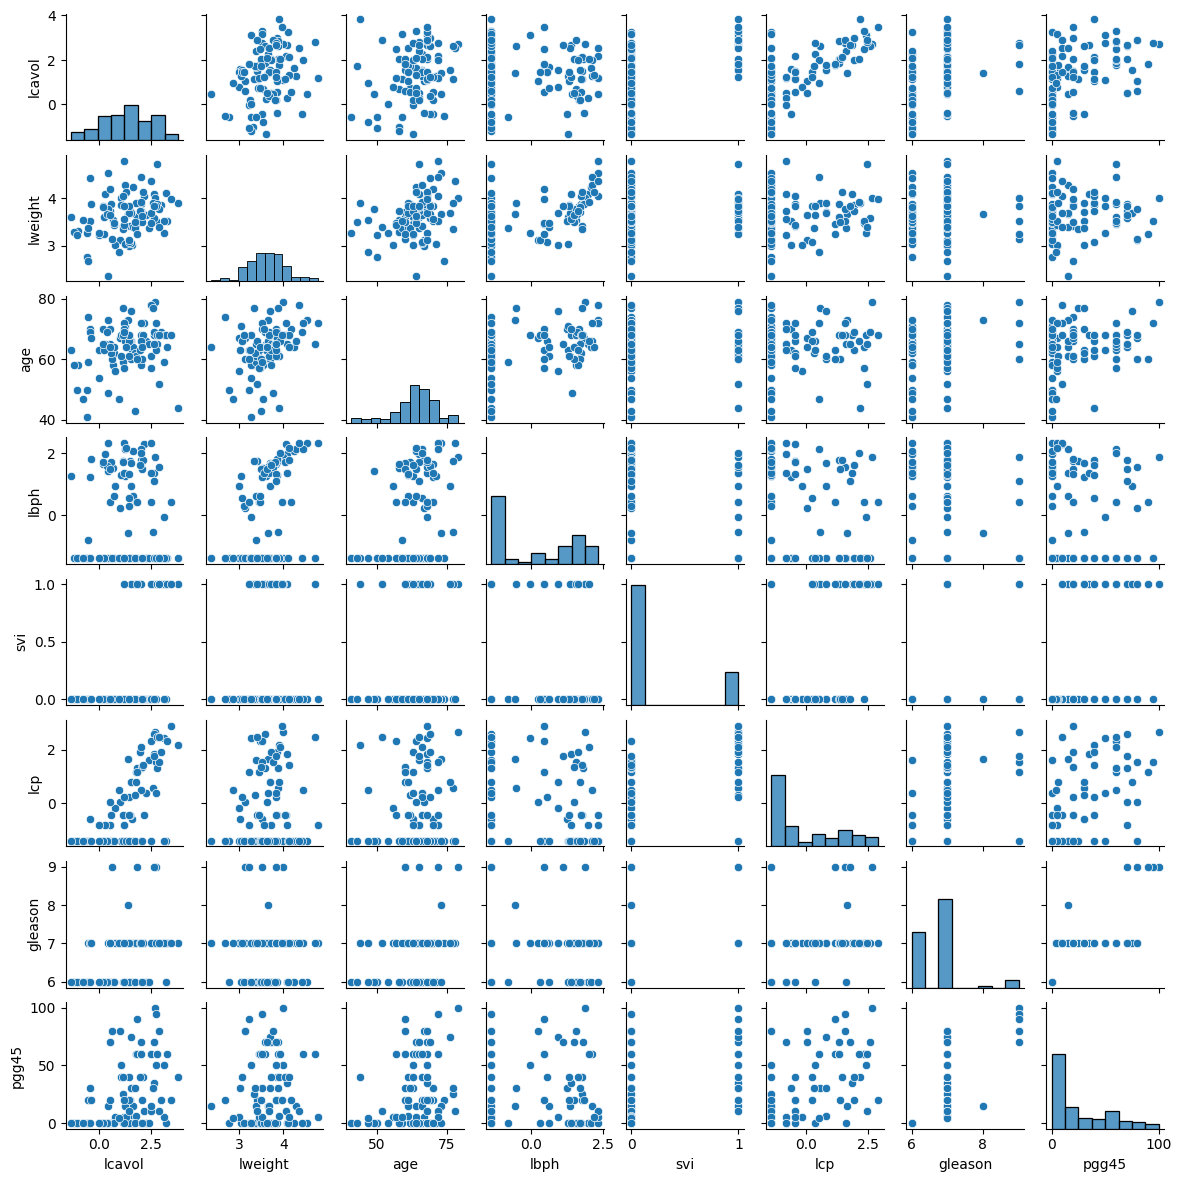

In [11]:
sns.pairplot(X_scaled, height=1.5);

### Ridge regression (Гребневая регрессия)

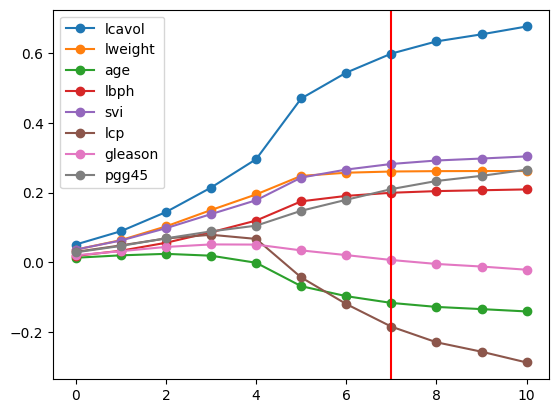

0.4971938434698418

In [35]:
# Ridge regression
#n_alpha = 30
#alpha_s = np.logspace(5, 0, n_alpha)
alpha_s = [ 1024, 512, 256, 128, 64, 16, 8, 4, 2, 1, 1e-05]

coefs = map(lambda a: linear_model.Ridge(alpha=a).fit(X_train_scaled, y_train).coef_.flatten(), alpha_s)
coefs = np.array(list(coefs))

# Ridge regression with cross validation
best_model = linear_model.RidgeCV(alpha_s)
b = best_model.fit(X_train_scaled, y_train)

fig, ax = plt.subplots()
plt.plot(coefs, marker="o")
plt.axvline(x=np.where(alpha_s == best_model.alpha_), c="r")
plt.legend(X_train_scaled.columns)
#pml.savefig("prostate_data.pdf")
plt.show()

y_pred = b.predict(X_test_scaled)

mean_squared_error(y_test, y_pred)

### Lasso regression (Лассо регрессия)

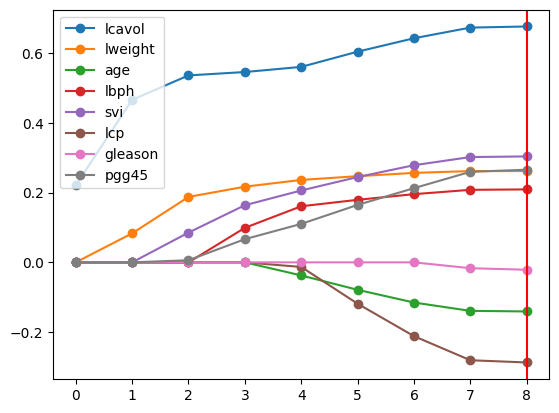

0.521273976369338

In [36]:
# Lasso regression
#n_alpha = 30
#alpha_s = np.linspace(0.0000000001, 1, n_alpha)
alpha_s = [0.680, 0.380, 0.209, 0.100, 0.044, 0.027, 0.012, 0.001, 0.00000001]

coefs = map(lambda a: linear_model.Lasso(alpha=a).fit(X_train_scaled, y_train).coef_.flatten(), alpha_s)
coefs = np.array(list(coefs))

# Lasso regression with cross validation
best_model = linear_model.LassoCV(alphas=alpha_s)
b = best_model.fit(X_train_scaled, y_train)

fig, ax = plt.subplots()
plt.plot(coefs, marker="o")
plt.axvline(x=np.where(alpha_s == best_model.alpha_), c="r")
plt.legend(X_train_scaled.columns)
plt.show()

y_pred = b.predict(X_test_scaled)

mean_squared_error(y_test, y_pred)

### ElasticNet = Ridge Regression + Lasso Regression

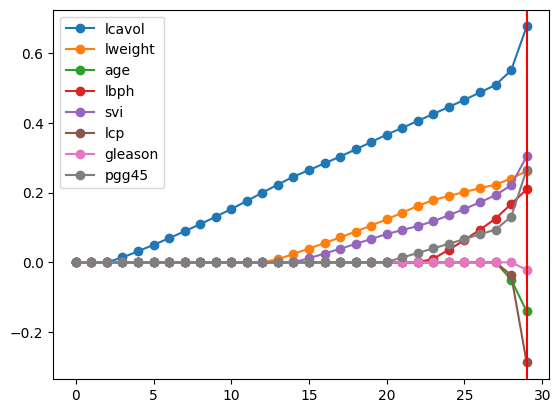

0.5212738273178942

In [42]:
# ElasticNet
n_alpha = 30
alpha_s = np.linspace(2, 0.0000001, n_alpha)

coefs = map(lambda a: linear_model.ElasticNet(alpha=a).fit(X_train_scaled, y_train).coef_.flatten(), alpha_s)
coefs = np.array(list(coefs))

# Lasso regression with cross validation
best_model = linear_model.ElasticNetCV(alphas=alpha_s)
b = best_model.fit(X_train_scaled, y_train)

fig, ax = plt.subplots()
plt.plot(coefs, marker="o")
plt.axvline(x=np.where(alpha_s == best_model.alpha_), c="r")
plt.legend(X_train_scaled.columns)
plt.show()

y_pred = b.predict(X_test_scaled)
mean_squared_error(y_test, y_pred)